开始加载数据...
数据加载完成，开始分析...
正在进行连通域分析...
检测到建筑物数量: 6740

正在计算建筑物大小...


处理建筑物: 100%|██████████| 6740/6740 [12:38<00:00,  8.88it/s]



正在生成统计信息...

基础统计 (像素单位):
最小建筑物大小: 12 pixels (108.0 m²)
最大建筑物大小: 180313 pixels (1622817.0 m²)
平均建筑物大小: 512.2 pixels (4609.6 m²)
中位数建筑物大小: 150.0 pixels (1350.0 m²)

分位数统计:
5分位数: 80.0 pixels (720.0 m²)
10分位数: 90.0 pixels (810.0 m²)
25分位数: 111.0 pixels (999.0 m²)
50分位数: 150.0 pixels (1350.0 m²)
75分位数: 334.2 pixels (3008.2 m²)
90分位数: 1242.1 pixels (11178.9 m²)
95分位数: 2117.0 pixels (19053.4 m²)

正在生成可视化图表...


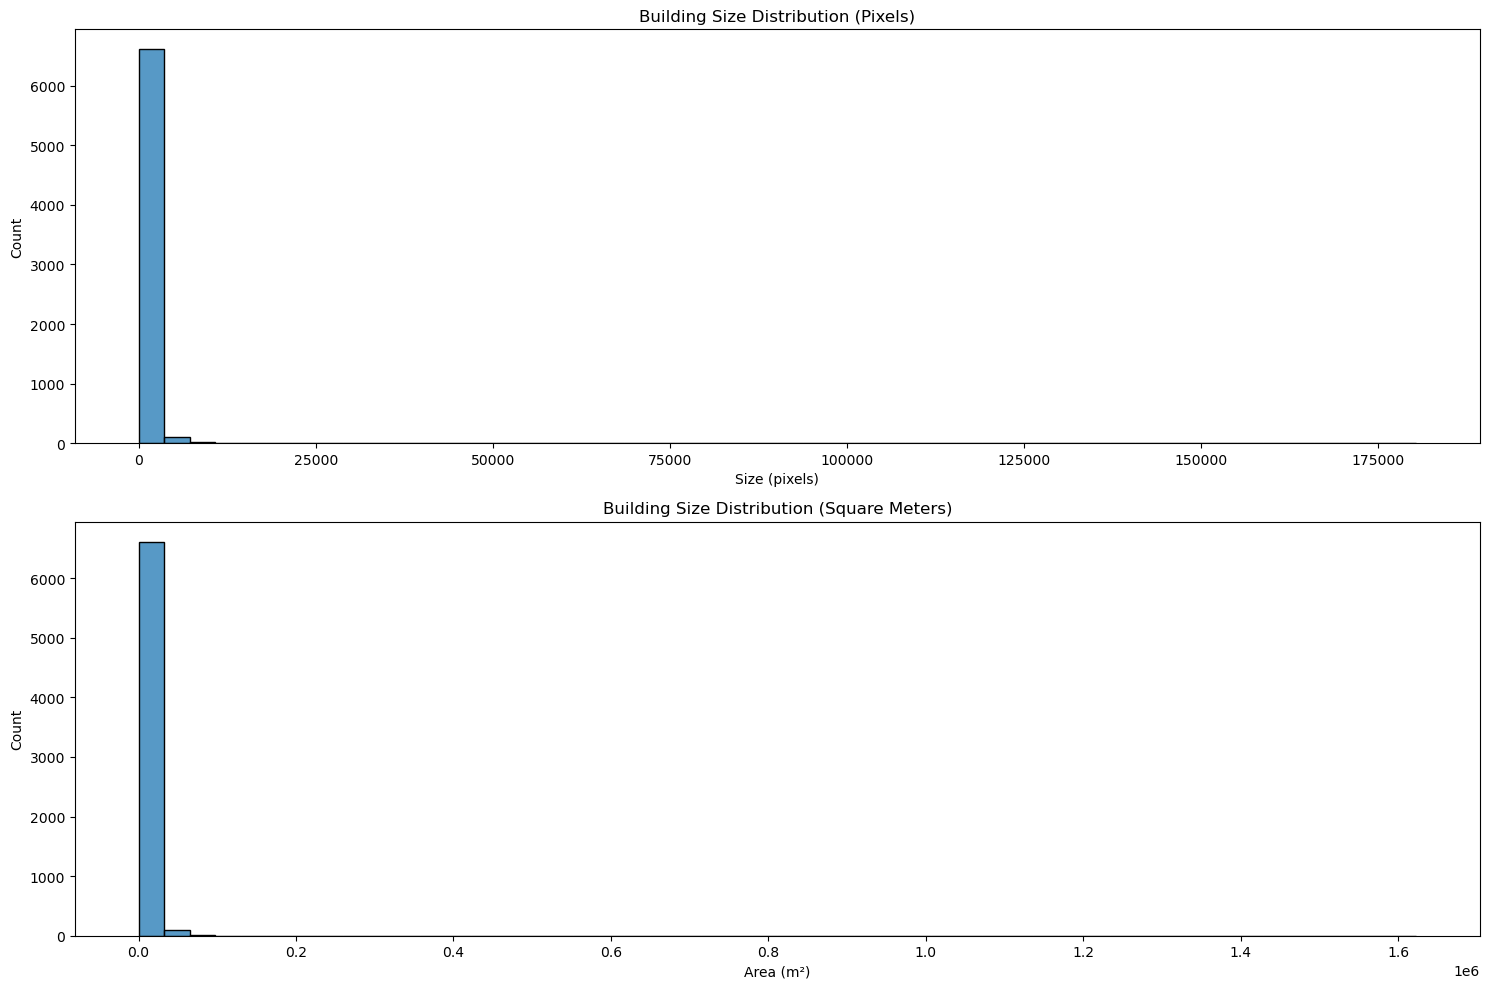


正在生成空间分布图...


生成空间分布图: 100%|██████████| 6740/6740 [15:10<00:00,  7.41it/s]


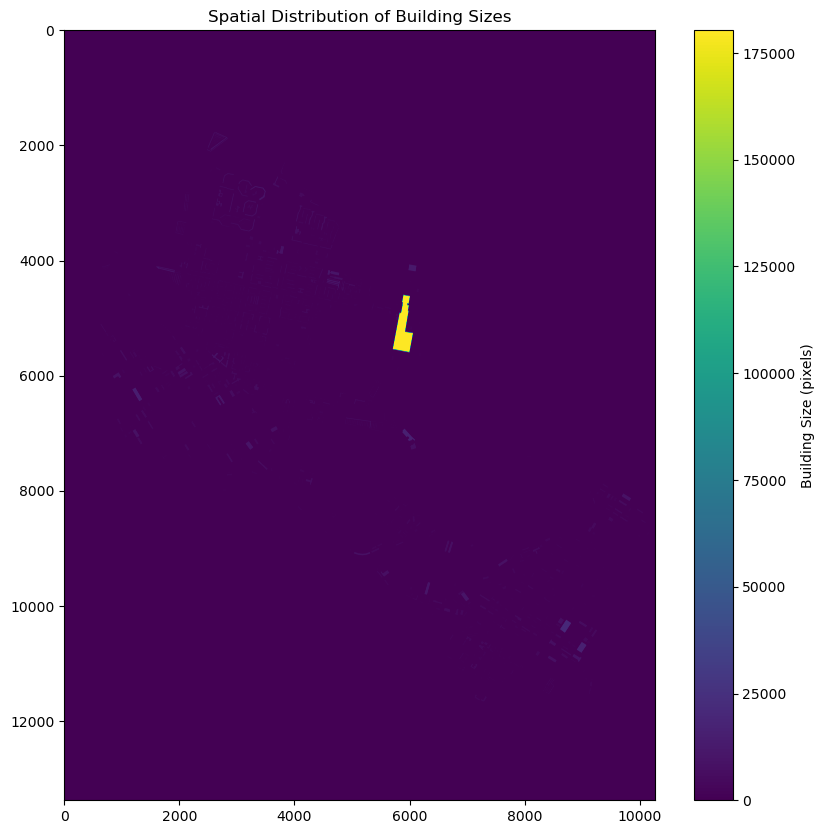


建议的阈值:
像素数: 111.0
实际面积: 999.0 m²
使用该阈值时，24.4%的建筑物会被标记为小型建筑


In [8]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
import seaborn as sns
from pathlib import Path
import logging
from tqdm import tqdm
Image.MAX_IMAGE_PIXELS = None  # 取消图像大小限制

logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# pixel_to_area函数保持不变...

def analyze_building_sizes(building_mask, resolution=3.0):
    """
    分析建筑物大小分布
    
    Args:
        building_mask: 二值化的建筑物mask图像
        resolution: 图像分辨率（米/像素）
    """
    # 连通域分析
    print("正在进行连通域分析...")
    building_labels = measure.label(building_mask)
    num_buildings = building_labels.max()
    print(f"检测到建筑物数量: {num_buildings}")
    
    # 收集建筑物大小
    print("\n正在计算建筑物大小...")
    sizes = []
    # 使用tqdm创建进度条
    for building_id in tqdm(range(1, num_buildings + 1), desc="处理建筑物"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        sizes.append(size)
    
    sizes = np.array(sizes)
    
    print("\n正在生成统计信息...")
    # 基础统计
    print("\n基础统计 (像素单位):")
    print(f"最小建筑物大小: {sizes.min()} pixels ({pixel_to_area(sizes.min(), resolution):.1f} m²)")
    print(f"最大建筑物大小: {sizes.max()} pixels ({pixel_to_area(sizes.max(), resolution):.1f} m²)")
    print(f"平均建筑物大小: {sizes.mean():.1f} pixels ({pixel_to_area(sizes.mean(), resolution):.1f} m²)")
    print(f"中位数建筑物大小: {np.median(sizes):.1f} pixels ({pixel_to_area(np.median(sizes), resolution):.1f} m²)")
    
    # 计算分位数
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    print("\n分位数统计:")
    for p in percentiles:
        value = np.percentile(sizes, p)
        print(f"{p}分位数: {value:.1f} pixels ({pixel_to_area(value, resolution):.1f} m²)")
    
    print("\n正在生成可视化图表...")
    # 绘图
    plt.figure(figsize=(15, 10))
    
    # 1. 大小分布直方图
    plt.subplot(2, 1, 1)
    sns.histplot(sizes, bins=50)
    plt.title('Building Size Distribution (Pixels)')
    plt.xlabel('Size (pixels)')
    plt.ylabel('Count')
    
    # 2. 面积分布直方图（平方米）
    plt.subplot(2, 1, 2)
    areas = [pixel_to_area(s, resolution) for s in sizes]
    sns.histplot(areas, bins=50)
    plt.title('Building Size Distribution (Square Meters)')
    plt.xlabel('Area (m²)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    print("\n正在生成空间分布图...")
    # 额外的可视化：建筑物大小的空间分布
    plt.figure(figsize=(10, 10))
    building_sizes = np.zeros_like(building_labels, dtype=float)
    for building_id in tqdm(range(1, num_buildings + 1), desc="生成空间分布图"):
        building_mask = building_labels == building_id
        building_sizes[building_mask] = np.sum(building_mask)
    
    plt.imshow(building_sizes, cmap='viridis')
    plt.colorbar(label='Building Size (pixels)')
    plt.title('Spatial Distribution of Building Sizes')
    plt.show()
    
    return sizes

# suggest_threshold函数保持不变...

# 主执行部分
print("开始加载数据...")
try:
    # 加载mask
    mask = np.array(Image.open(building_mask_path))
    if mask.ndim > 2:
        print("检测到多通道图像，转换为单通道...")
        mask = mask[:,:,0]  # 如果是多通道，取第一个通道
    mask = mask > 0  # 二值化
    print("数据加载完成，开始分析...")
    
    # 分析建筑物大小分布
    sizes = analyze_building_sizes(mask, resolution)
    
    # 获取建议的阈值
    suggested_threshold = suggest_threshold(sizes, resolution)
    
except Exception as e:
    print(f"分析过程中出现错误: {e}")

开始加载数据...
数据加载完成，开始分析...
正在进行连通域分析...
检测到建筑物数量: 6740

正在计算建筑物大小...


处理建筑物: 100%|██████████| 6740/6740 [13:22<00:00,  8.40it/s]



统计信息:
总建筑物数量: 6740
正常建筑物数量: 5574
异常值数量: 1166


C:\Users\xiao\AppData\Local\Temp\ipykernel_46720\3706563607.py:98: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
c:\Users\xiao\anaconda\envs\xbd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


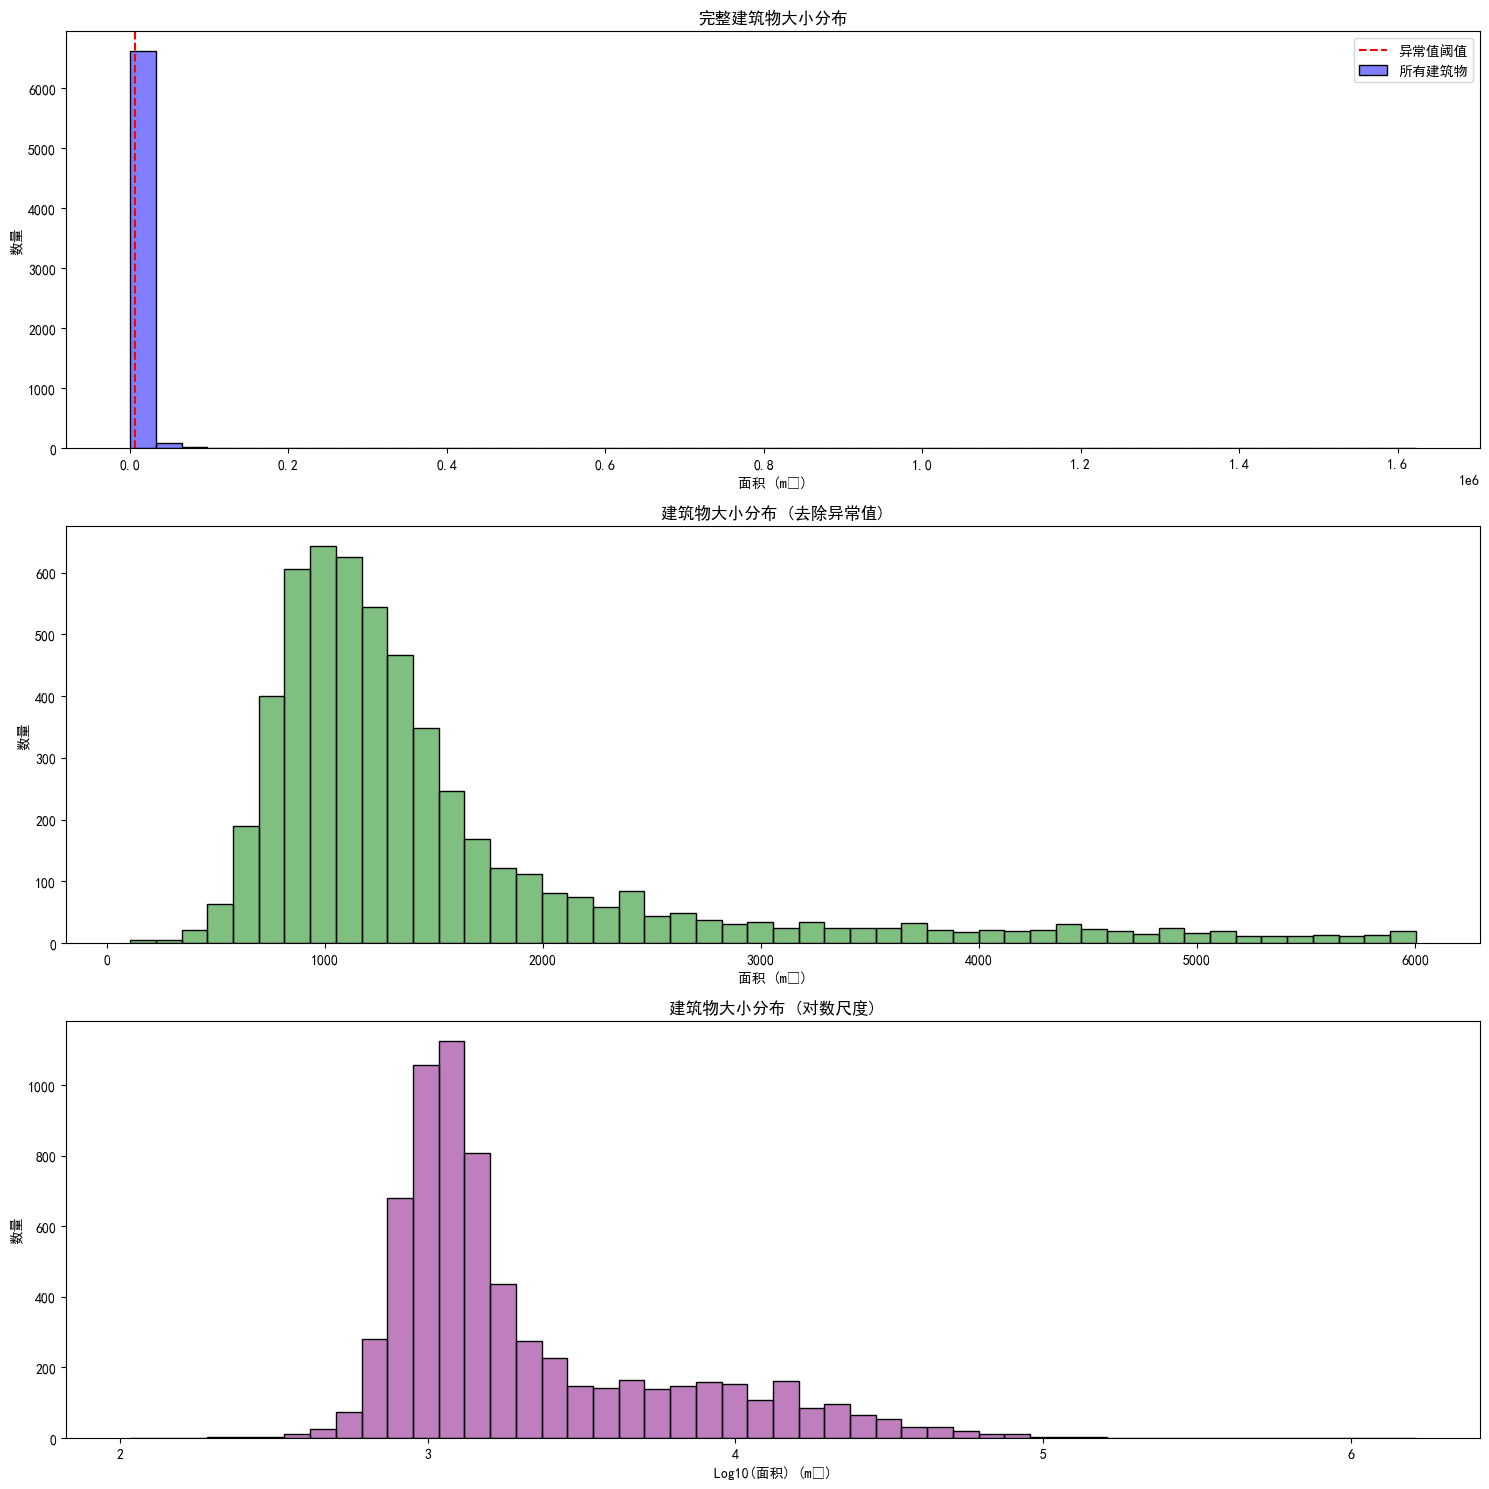

c:\Users\xiao\anaconda\envs\xbd\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


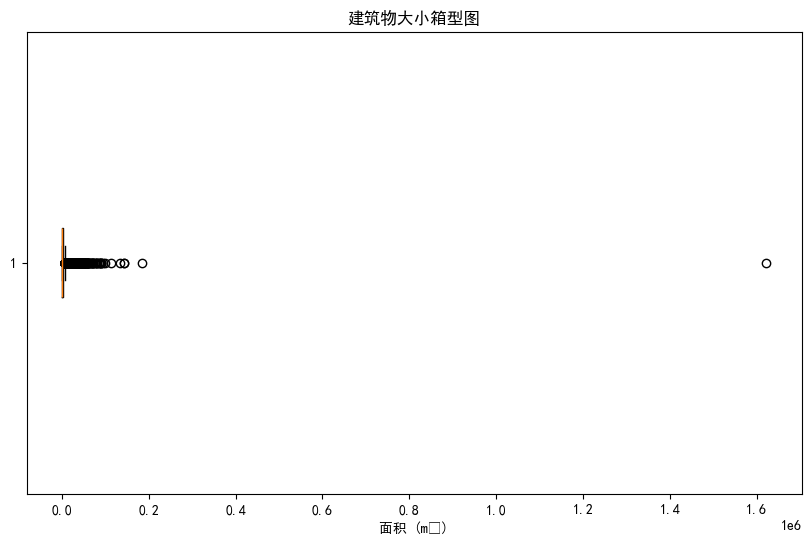


正常值统计 (去除异常值后):
最小面积: 108.0 m²
最大面积: 6003.0 m²
平均面积: 1553.9 m²
中位数面积: 1215.0 m²


生成空间分布图: 100%|██████████| 6740/6740 [18:04<00:00,  6.22it/s]


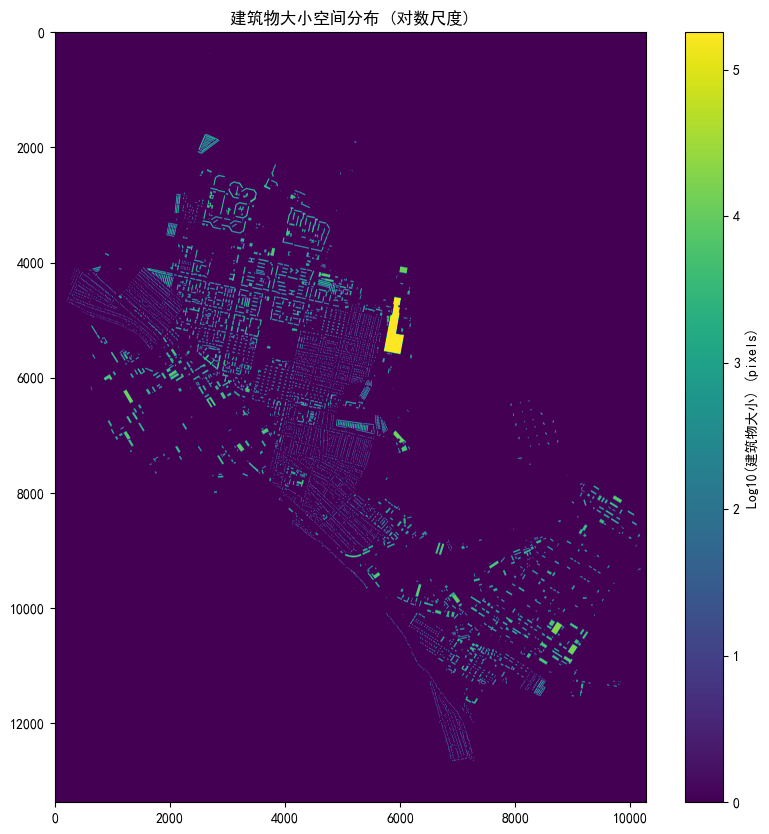

In [11]:
# 首先导入所需的库
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage import measure
import seaborn as sns
from pathlib import Path
import logging
from tqdm import tqdm
from scipy import stats

# 设置基本配置
Image.MAX_IMAGE_PIXELS = None  # 取消图像大小限制
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号
def pixel_to_area(pixels, resolution=3.0):
    """
    将像素数转换为实际面积（平方米）
    
    Args:
        pixels: 像素数
        resolution: 分辨率（米/像素）
    """
    return pixels * (resolution ** 2)
def analyze_building_sizes(building_mask, resolution=3.0):
    """
    分析建筑物大小分布，处理异常值的影响
    
    Args:
        building_mask: 二值化的建筑物mask图像
        resolution: 图像分辨率（米/像素）
    """
    # 连通域分析
    print("正在进行连通域分析...")
    building_labels = measure.label(building_mask)
    num_buildings = building_labels.max()
    print(f"检测到建筑物数量: {num_buildings}")
    
    # 收集建筑物大小
    print("\n正在计算建筑物大小...")
    sizes = []
    for building_id in tqdm(range(1, num_buildings + 1), desc="处理建筑物"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        sizes.append(size)
    
    sizes = np.array(sizes)
    areas = np.array([pixel_to_area(s, resolution) for s in sizes])
    
    # 计算异常值界限
    Q1 = np.percentile(sizes, 25)
    Q3 = np.percentile(sizes, 75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    # 分离正常值和异常值
    normal_sizes = sizes[sizes <= upper_bound]
    outlier_sizes = sizes[sizes > upper_bound]
    normal_areas = areas[sizes <= upper_bound]
    outlier_areas = areas[sizes > upper_bound]
    
    print("\n统计信息:")
    print(f"总建筑物数量: {len(sizes)}")
    print(f"正常建筑物数量: {len(normal_sizes)}")
    print(f"异常值数量: {len(outlier_sizes)}")
    
    # 创建多子图可视化
    plt.figure(figsize=(15, 15))
    
    # 1. 原始分布（带异常值标记）
    plt.subplot(3, 1, 1)
    sns.histplot(data=areas, bins=50, color='blue', alpha=0.5, label='所有建筑物')
    plt.axvline(pixel_to_area(upper_bound, resolution), color='red', linestyle='--', 
                label='异常值阈值')
    plt.title('完整建筑物大小分布')
    plt.xlabel('面积 (m²)')
    plt.ylabel('数量')
    plt.legend()
    
    # 2. 正常值分布（去除异常值）
    plt.subplot(3, 1, 2)
    sns.histplot(data=normal_areas, bins=50, color='green', alpha=0.5)
    plt.title('建筑物大小分布 (去除异常值)')
    plt.xlabel('面积 (m²)')
    plt.ylabel('数量')
    
    # 3. 对数尺度分布
    plt.subplot(3, 1, 3)
    sns.histplot(data=np.log10(areas), bins=50, color='purple', alpha=0.5)
    plt.title('建筑物大小分布 (对数尺度)')
    plt.xlabel('Log10(面积) (m²)')
    plt.ylabel('数量')
    
    plt.tight_layout()
    plt.show()
    
    # 箱型图展示
    plt.figure(figsize=(10, 6))
    plt.boxplot(areas, vert=False, whis=1.5)
    plt.title('建筑物大小箱型图')
    plt.xlabel('面积 (m²)')
    plt.show()
    
    # 统计摘要
    print("\n正常值统计 (去除异常值后):")
    print(f"最小面积: {normal_areas.min():.1f} m²")
    print(f"最大面积: {normal_areas.max():.1f} m²")
    print(f"平均面积: {normal_areas.mean():.1f} m²")
    print(f"中位数面积: {np.median(normal_areas):.1f} m²")
    
    # 空间分布图（使用对数尺度）
    plt.figure(figsize=(10, 10))
    building_sizes = np.zeros_like(building_labels, dtype=float)
    for building_id in tqdm(range(1, num_buildings + 1), desc="生成空间分布图"):
        building_mask = building_labels == building_id
        size = np.sum(building_mask)
        # 使用对数尺度表示大小
        building_sizes[building_mask] = np.log10(size) if size > 0 else 0
    
    plt.imshow(building_sizes, cmap='viridis')
    plt.colorbar(label='Log10(建筑物大小) (pixels)')
    plt.title('建筑物大小空间分布 (对数尺度)')
    plt.show()
    
    return sizes, normal_sizes, outlier_sizes
# 主执行部分
# 替换为你的mask文件路径
building_mask_path = "../buildingmasks/mask_Rubizhne.tif"

print("开始加载数据...")
try:
    # 加载mask
    mask = np.array(Image.open(building_mask_path))
    if mask.ndim > 2:
        print("检测到多通道图像，转换为单通道...")
        mask = mask[:,:,0]  # 如果是多通道，取第一个通道
    mask = mask > 0  # 二值化
    print("数据加载完成，开始分析...")
    
    # 分析建筑物大小分布
    sizes, normal_sizes, outlier_sizes = analyze_building_sizes(mask, resolution=3.0)
    
except Exception as e:
    print(f"分析过程中出现错误: {e}")
